# WT time series model - testing for changes along the time course 
Following procedure described in https://www.nxn.se/valent/timecourse-analysis-with-sleuth

In [31]:
library(sleuth)
library(splines)
library(scales)
library(ggplot2)

In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
d$phase=ordered(ifelse(d$Time<9, "early","late"),levels=c("early","late"))
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”



 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,phase
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<ord>
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early
4,4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early
5,5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early
6,6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)
table(d$GT,d$phase)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

          
           early late
  deltaDEK     5    9
  LG3          5    9
  Loop         5    9
  OE           4    9
  WT           5    9

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

,target_id,gene,class,TYPE
,<chr>,<chr>,<chr>,<chr>
1,Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
2,Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
3,Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
4,Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
5,Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
6,Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT")))
head(D)
table(D$GT,D$Time)
table(D$Time,D$phase)

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,phase,path
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<ord>,<chr>
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early,../kallisto/kallisto/1-W3/abundance.h5
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early,../kallisto/kallisto/2-W3-2/abundance.h5
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early,../kallisto/kallisto/3-W3-3/abundance.h5
15,15-W5,15.W5,6,WT,5,normal,normal,absent,absent,absent,normal,absent,absent,1,5d_b1,early,../kallisto/kallisto/15-W5/abundance.h5
16,16-W5-2,16.W5.2,6,WT,5,normal,normal,absent,absent,absent,normal,absent,absent,2,5d_b2,early,../kallisto/kallisto/16-W5-2/abundance.h5
30,30-W9,30.W9,11,WT,9,normal,normal,normal,normal,absent,normal,absent,absent,1,9d_b1,late,../kallisto/kallisto/30-W9/abundance.h5


    
     3 5 9 12 14
  WT 3 2 3  3  3

    
     early late
  3      3    0
  5      2    0
  9      0    3
  12     0    3
  14     0    3

In [34]:
so=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', 
               gene_mode = TRUE,extra_bootstrap_summary = TRUE,read_bootstrap_tpm=TRUE, num_cores=10)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.

reading in kallisto results

dropping unused factor levels

.
.
.
.
.
.
.
.
.
.
.
.
.
.


normalizing est_counts

44905 targets passed the filter

normalizing tpm

merging in metadata

aggregating by column: gene

21752 genes passed the filter

Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”
summarizing bootstraps





In [35]:
options(repr.plot.width=12, repr.plot.height=10)


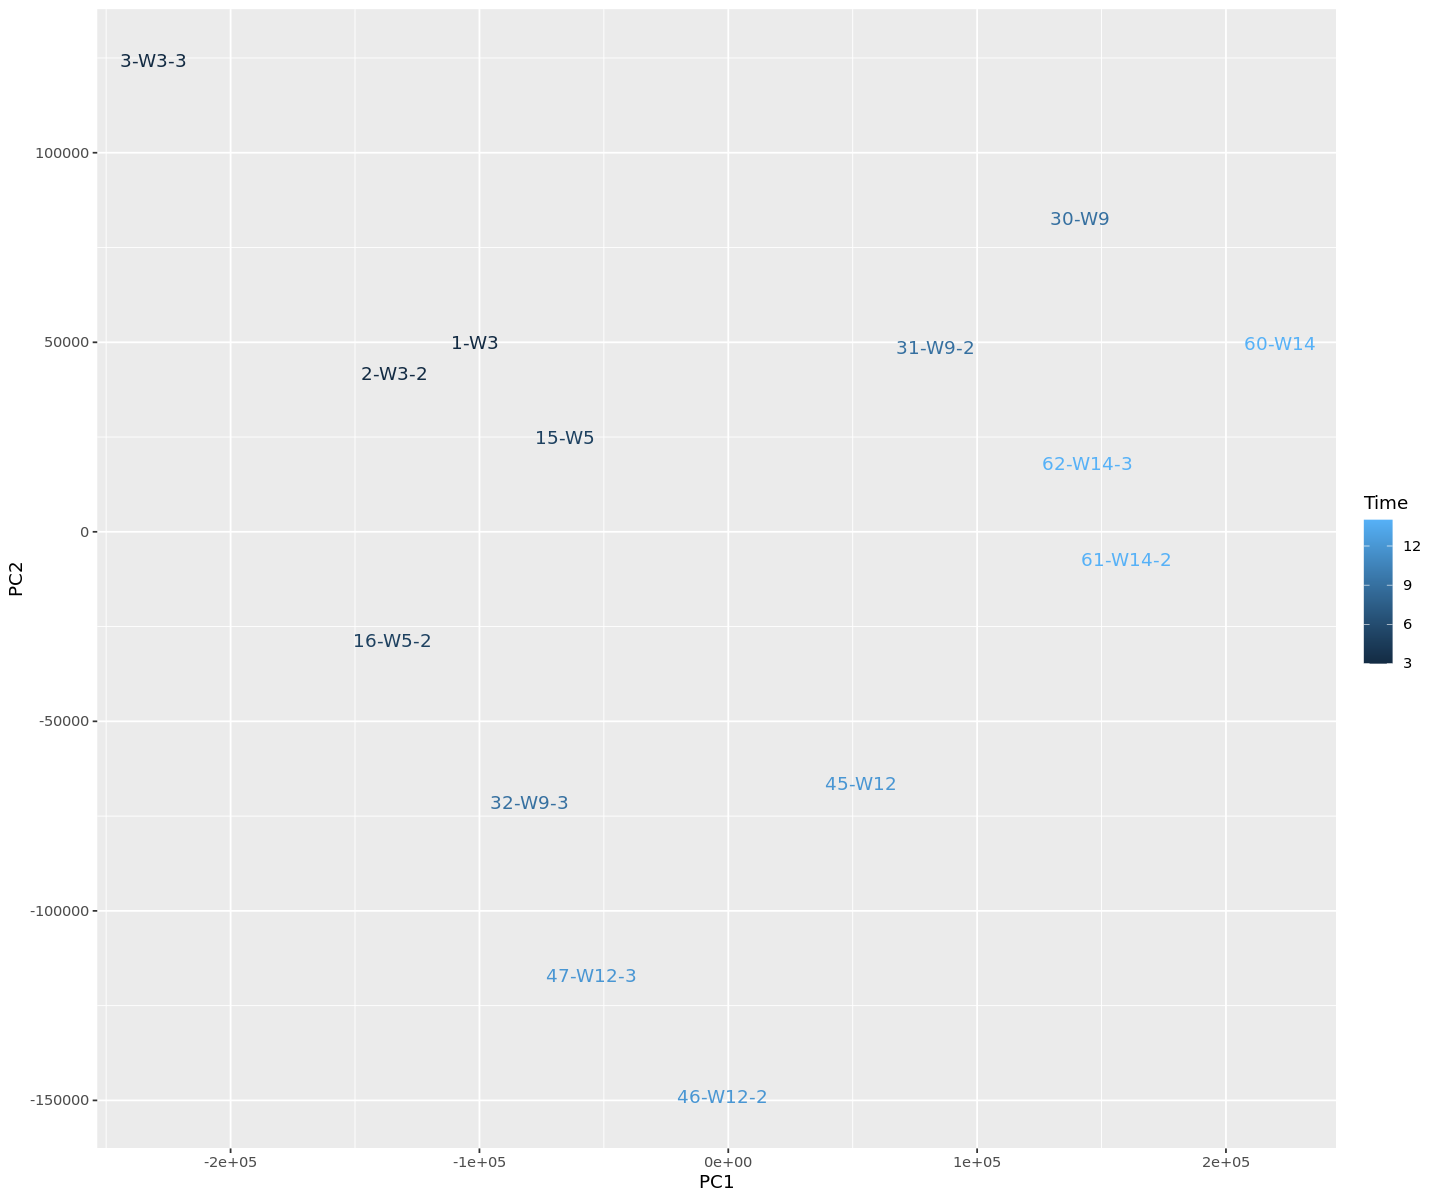

In [36]:
plot_pca(so, color_by = 'Time',text_labels = TRUE,units='scaled_reads_per_base')

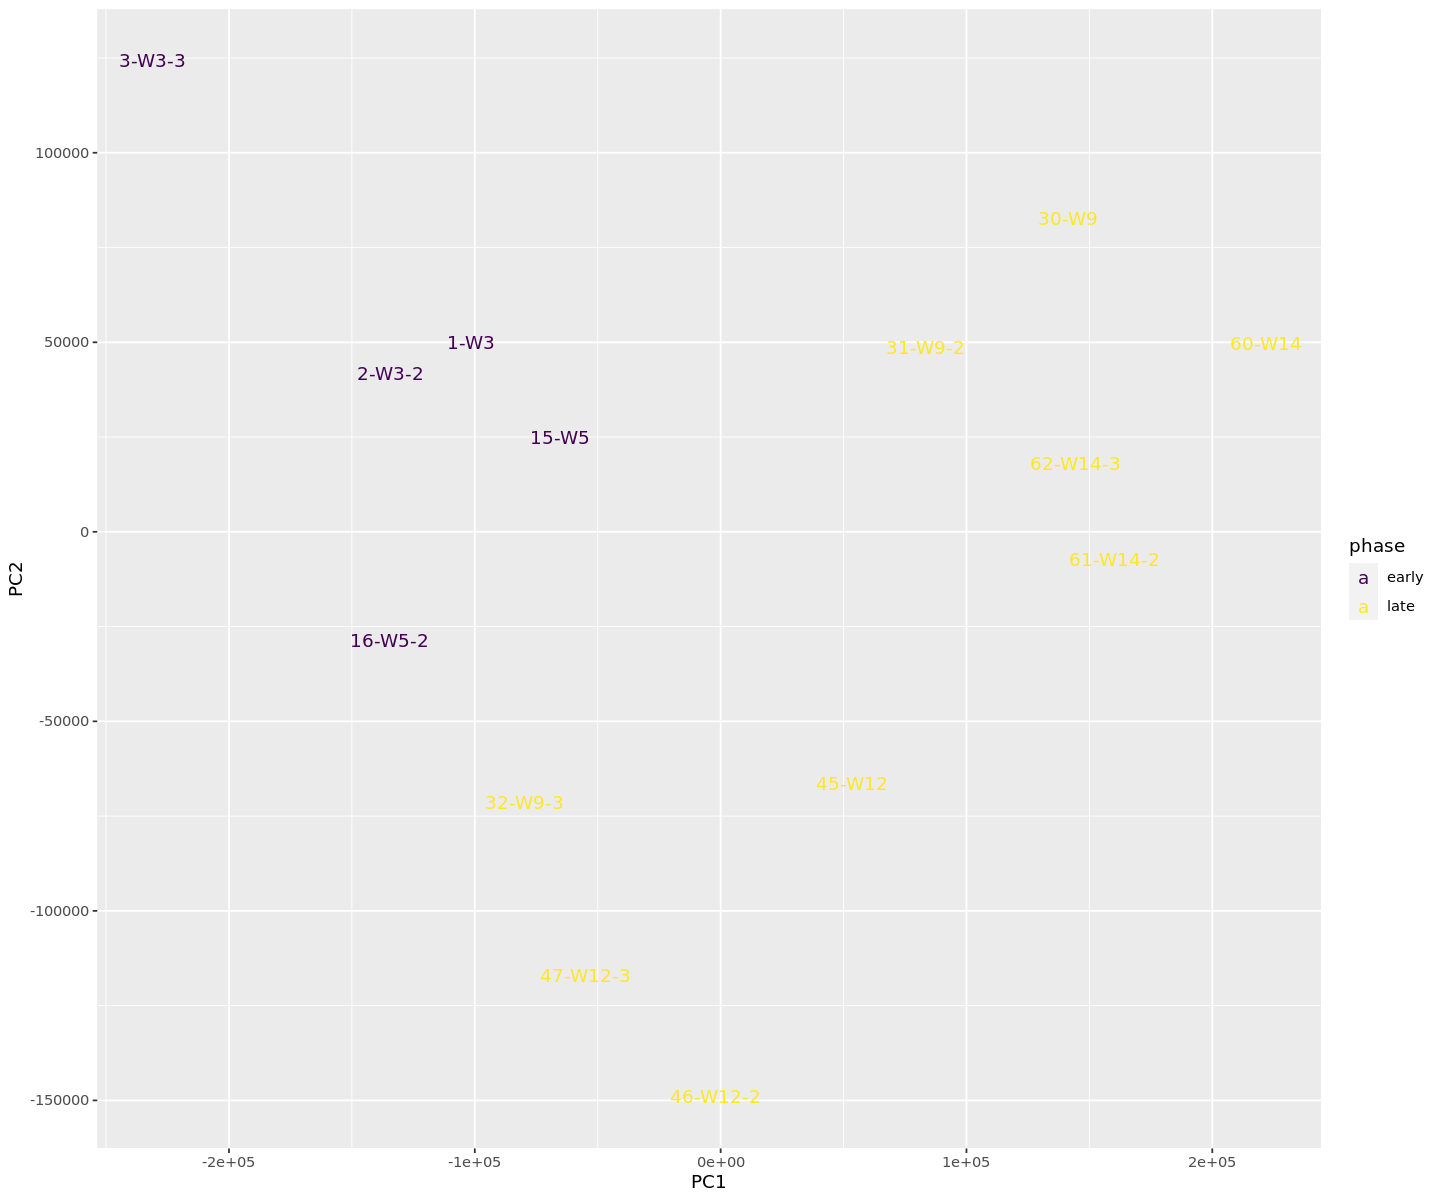

In [37]:
plot_pca(so, color_by = 'phase',text_labels = TRUE,units='scaled_reads_per_base')

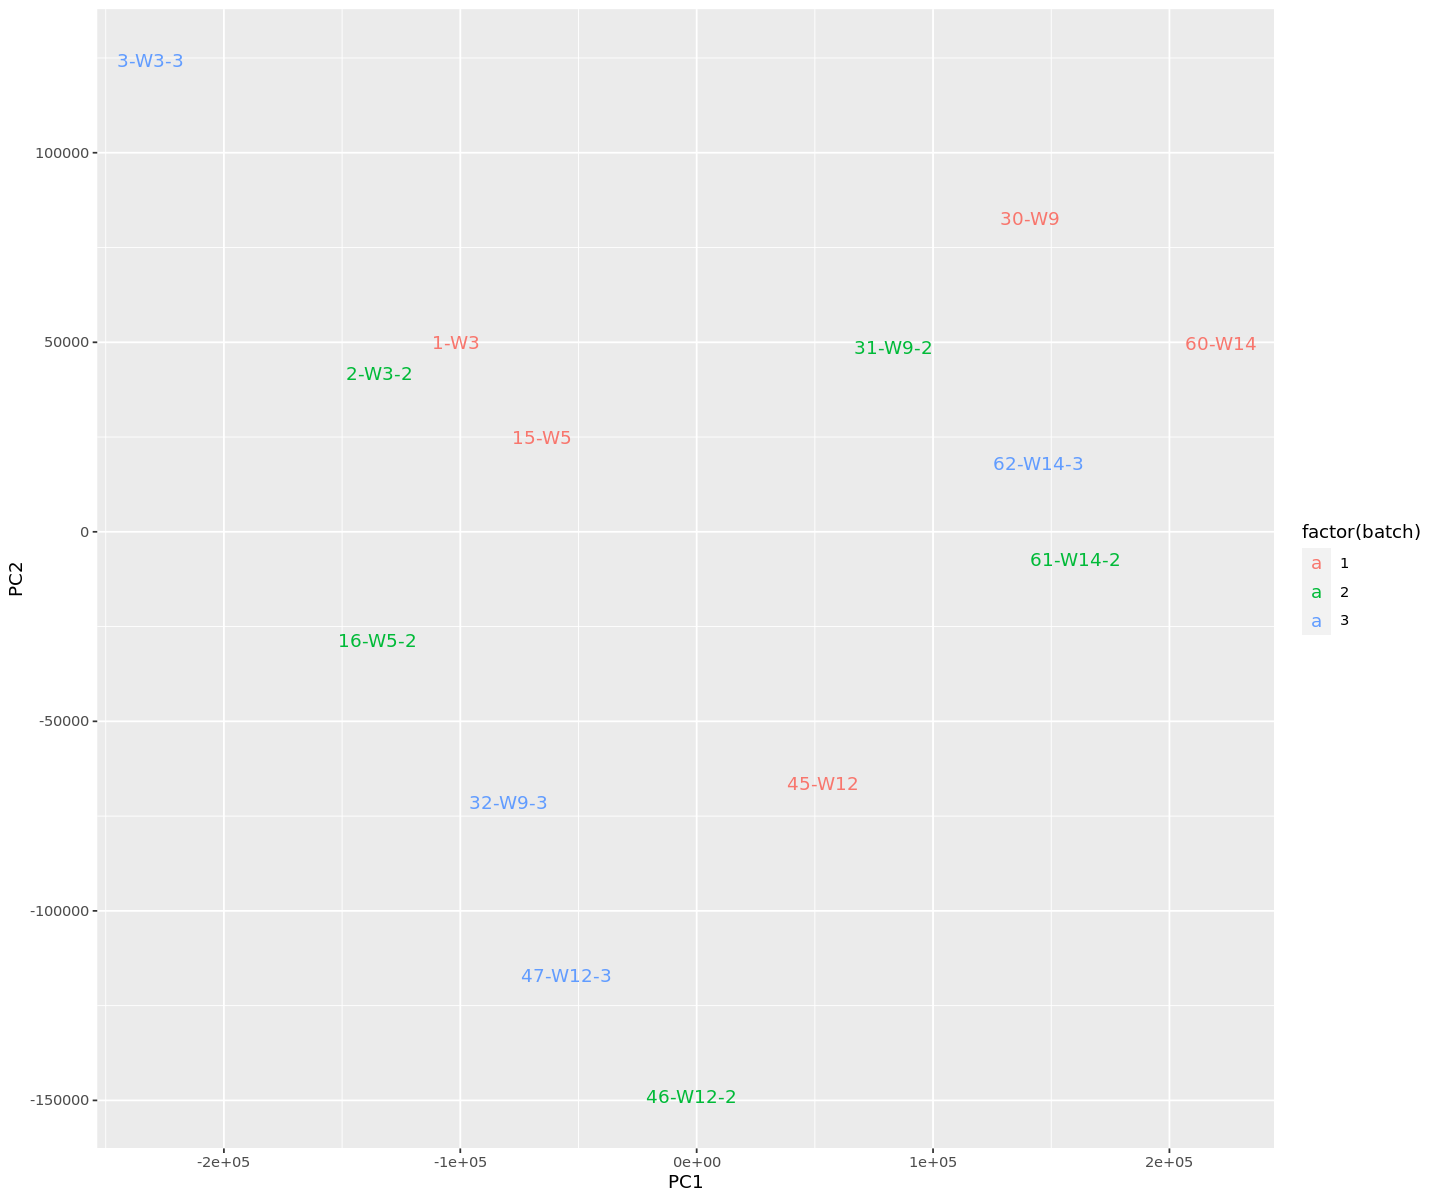

In [38]:
plot_pca(so, color_by = 'factor(batch)',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

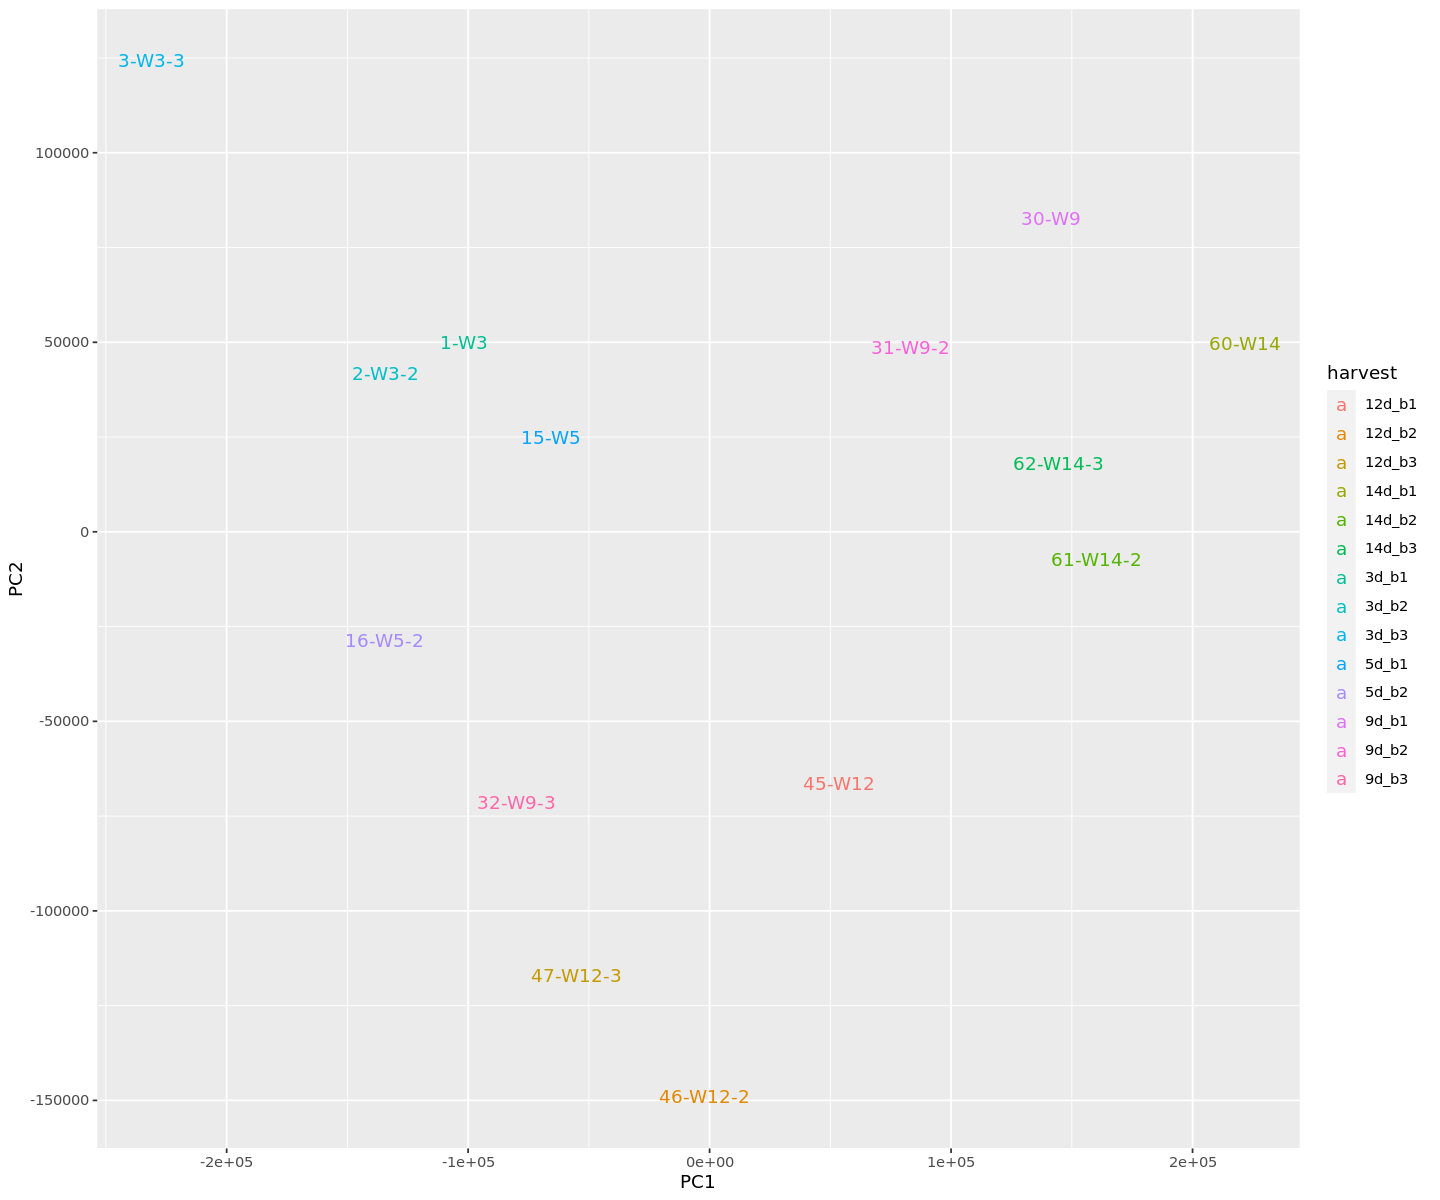

In [39]:
plot_pca(so, color_by = 'harvest',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

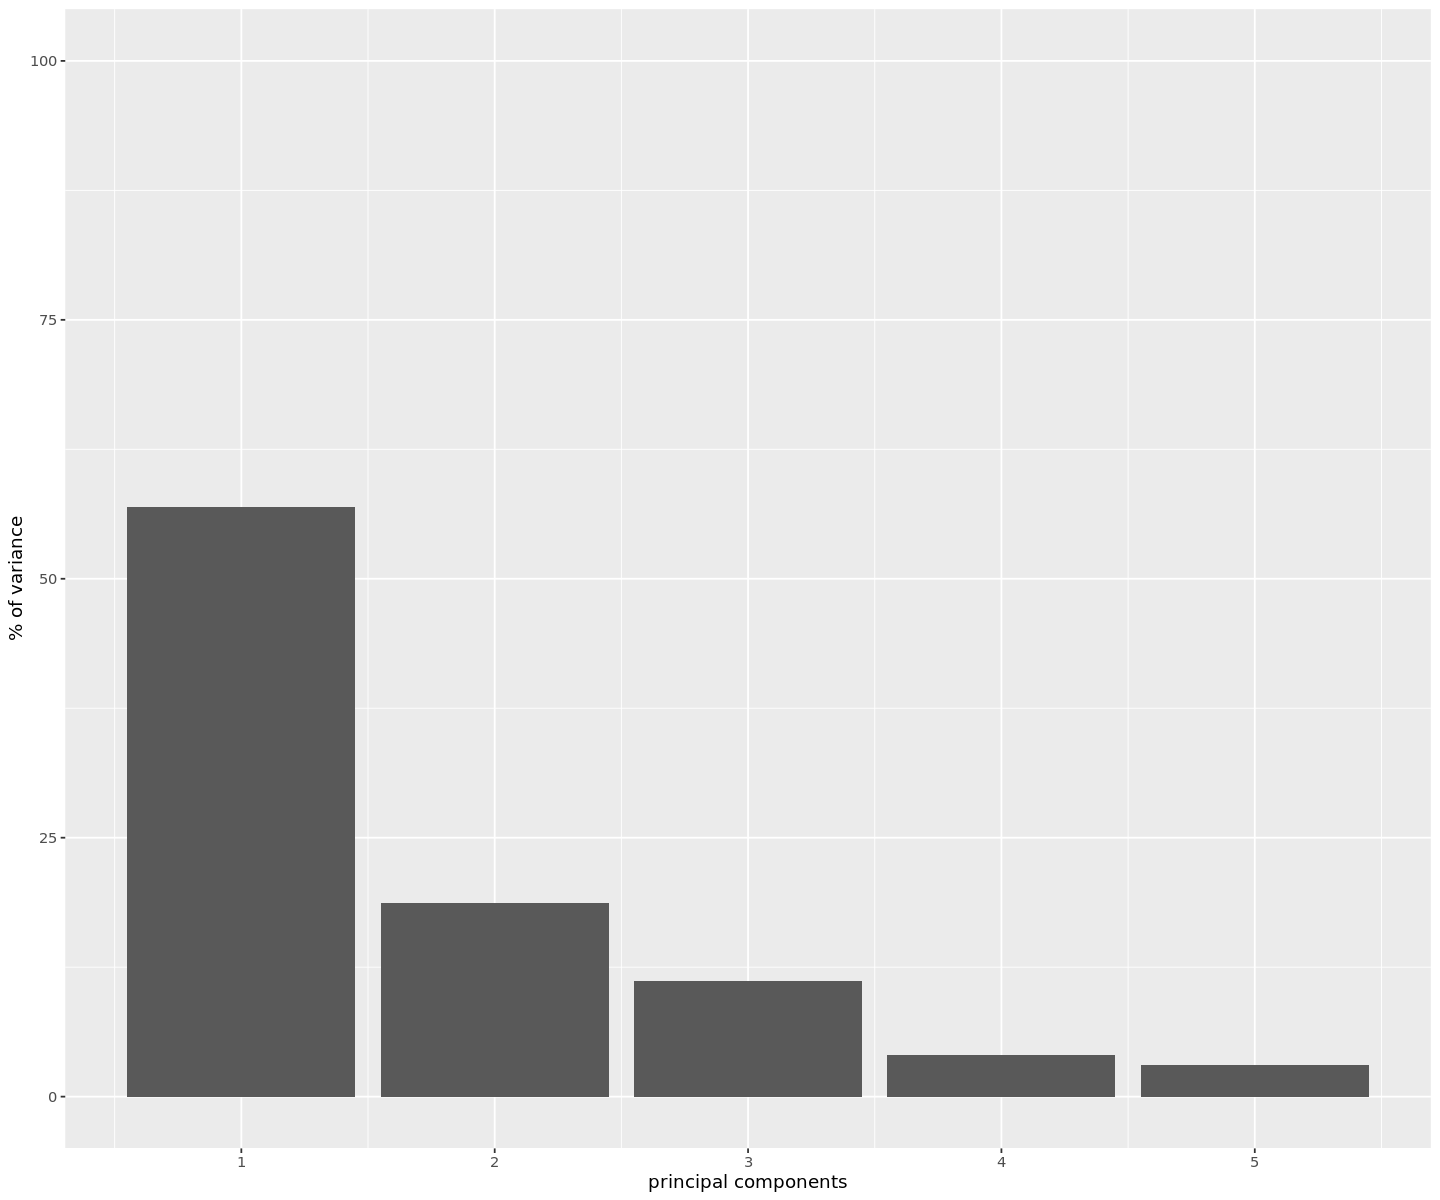

In [40]:
plot_pc_variance(so,units='scaled_reads_per_base')

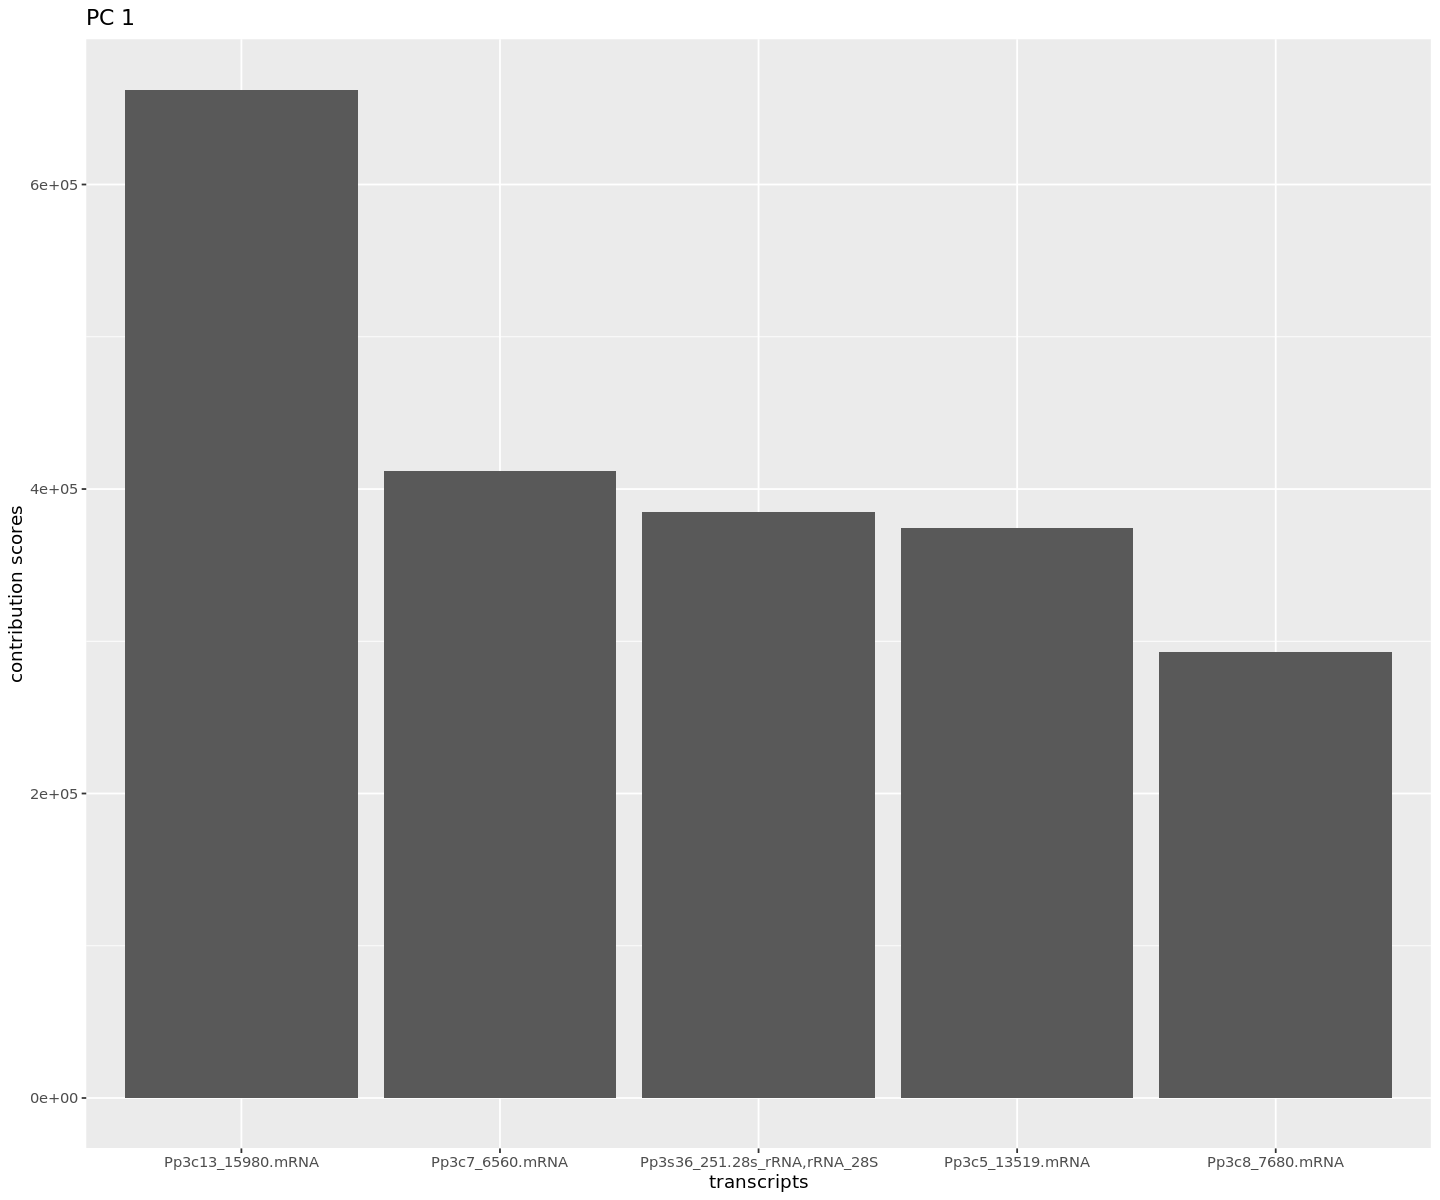

In [41]:
plot_loadings(so, pc_input = 1,units='scaled_reads_per_base')

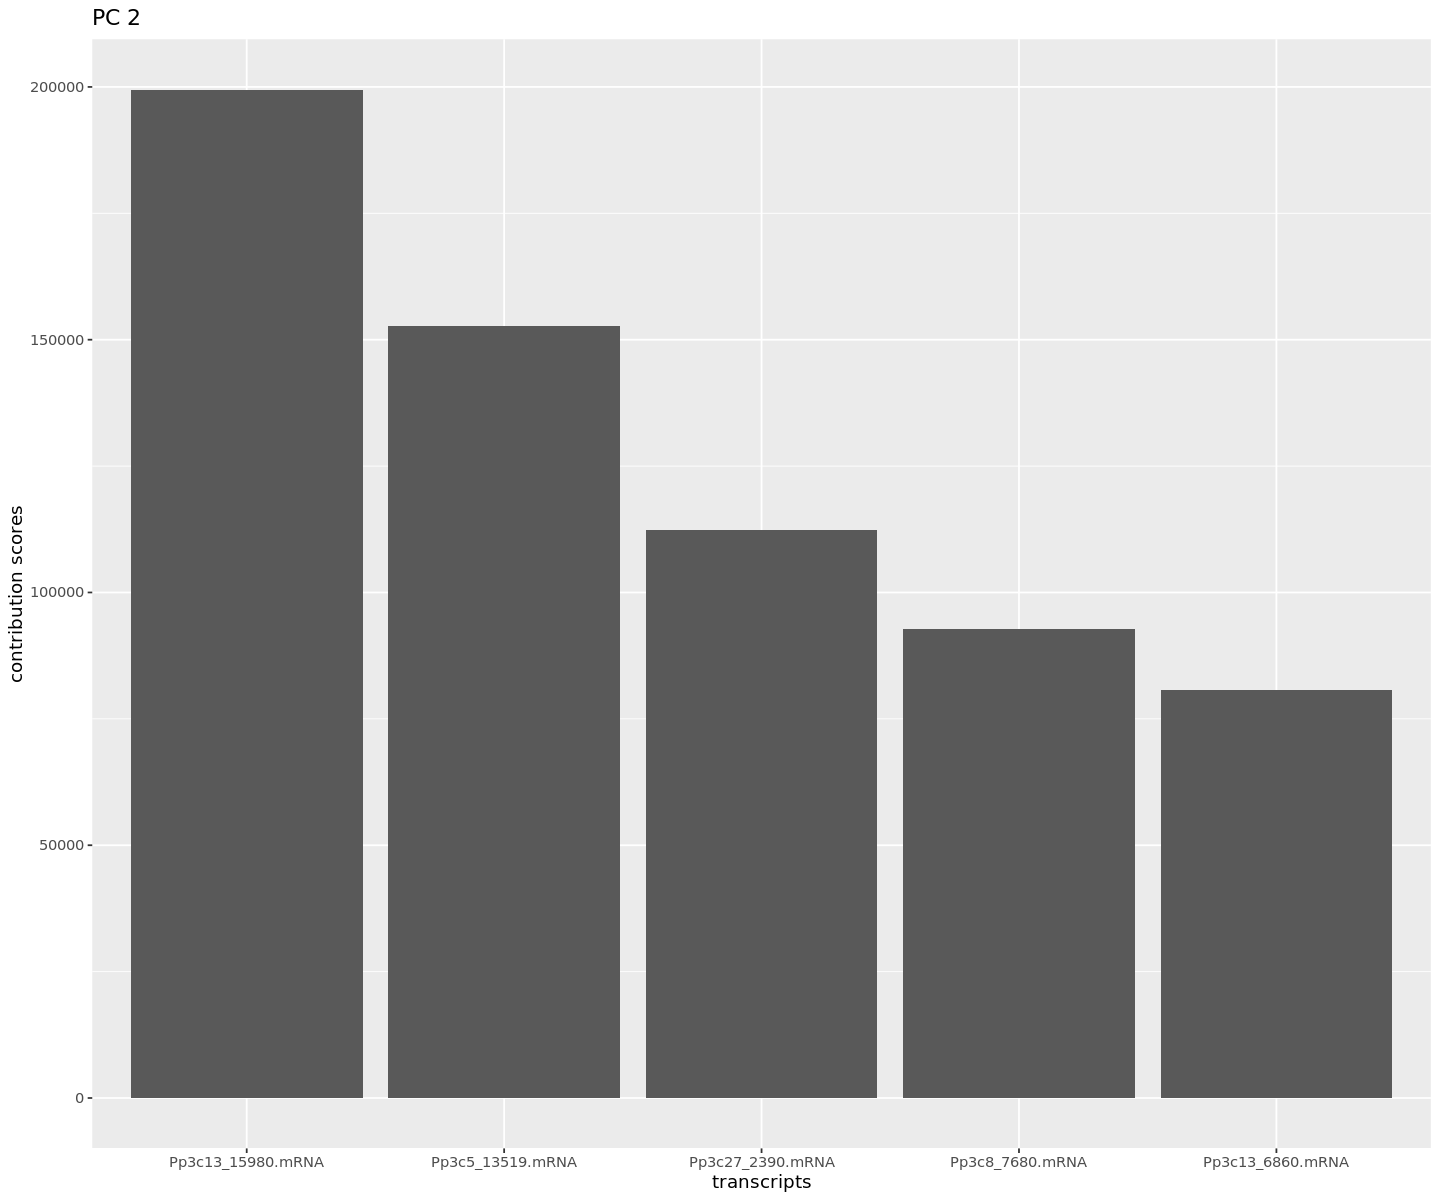

In [42]:
plot_loadings(so, pc_input = 2,units='scaled_reads_per_base')

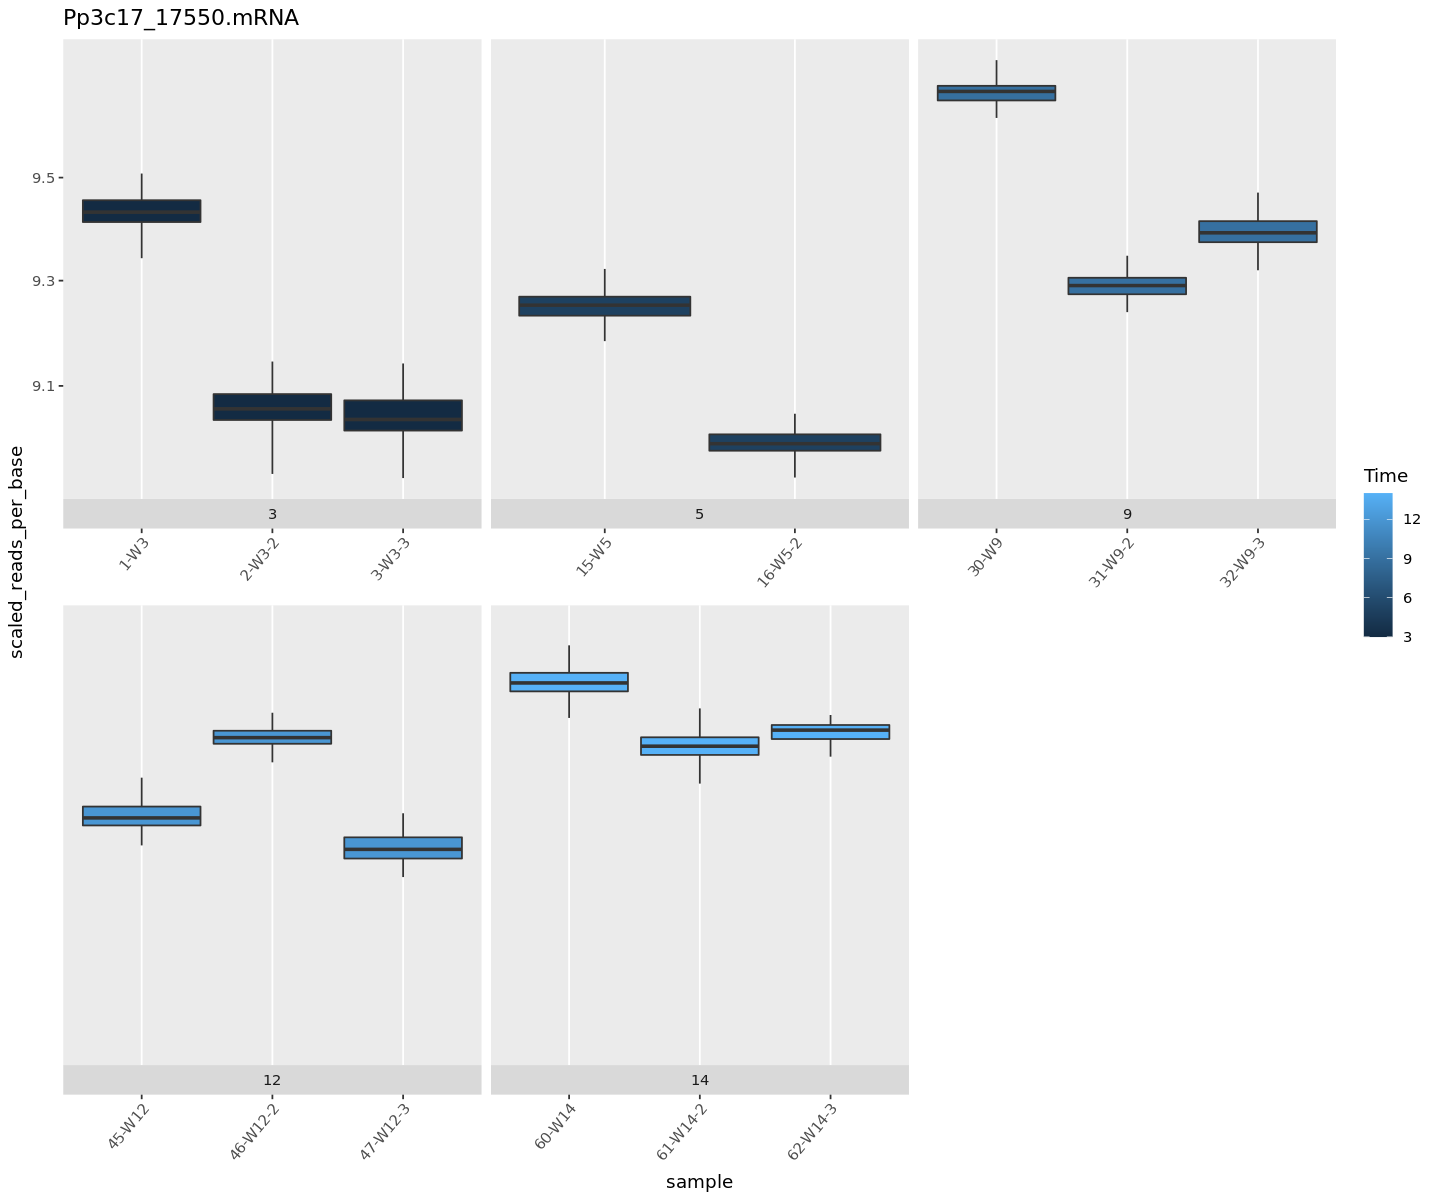

In [46]:
plot_bootstrap(so, 'Pp3c17_17550.mRNA', color_by = 'Time',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

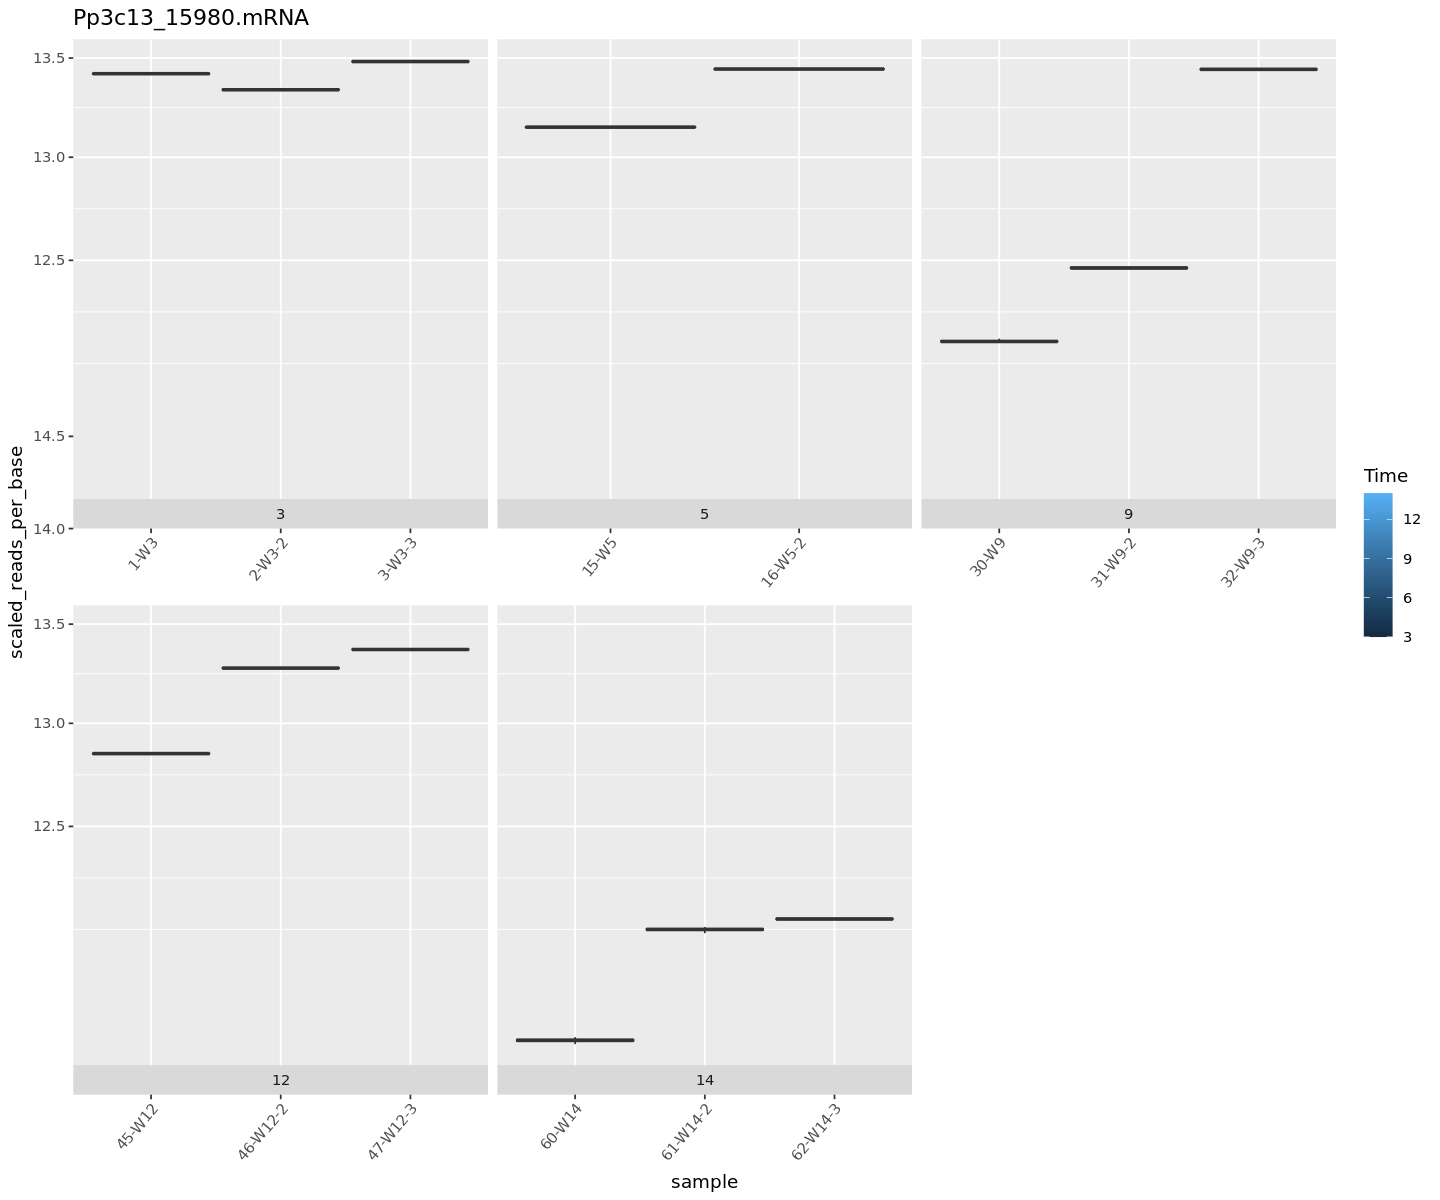

In [47]:
plot_bootstrap(so, 'Pp3c13_15980.mRNA', color_by = 'Time',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [48]:
full_design <- model.matrix(formula(~ ns(Time, df = 4)),data=D)
reduced_design <- model.matrix(formula(~ 1),data=D)

In [49]:
so= sleuth_fit(so,reduced_design,fit_name="reduced")

fitting measurement error models

shrinkage estimation

1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c13_15980.mRNA

computing variance of betas



In [50]:
so= sleuth_fit(so, full_design, fit_name = "full")

fitting measurement error models

shrinkage estimation

1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c13_15980.mRNA

computing variance of betas



In [51]:
so = sleuth_lrt(so, "reduced", "full")

In [52]:
models(so)

[  reduced  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), .Dim = c(14L,  1L), .Dimnames = list(c("1", "2", "3", "15", "16", "30", "31",  "32", "45", "46", "47", "60", "61", "62"), "(Intercept)"), assign = 0L) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
[  full  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,  0.0740740740740741, 0.0740740740740741, 0.603174603174603, 0.603174603174603,  0.603174603174603, 0.0888888888888889, 0.0888888888888889, 0.0888888888888889,  0, 0, 0, 0, 0, 0, -0.130189045660703, -0.130189045660703, 0.209559381722464,  0.209559381722464, 0.209559381722464, 0.587464387464387, 0.587464387464387,  0.587464387464387, -0.128205128205128, -0.128205128205128, -0.128205128205128,  0, 0, 0, 0.45566165981246, 0.45566165981246, 0.155431052860264,  0.155431052860264, 0.155431052860264, 0.232763532763533, 0.232763532763533,  0.232763532763533, 0.448717948717949, 0.448717948717949, 0.448717948

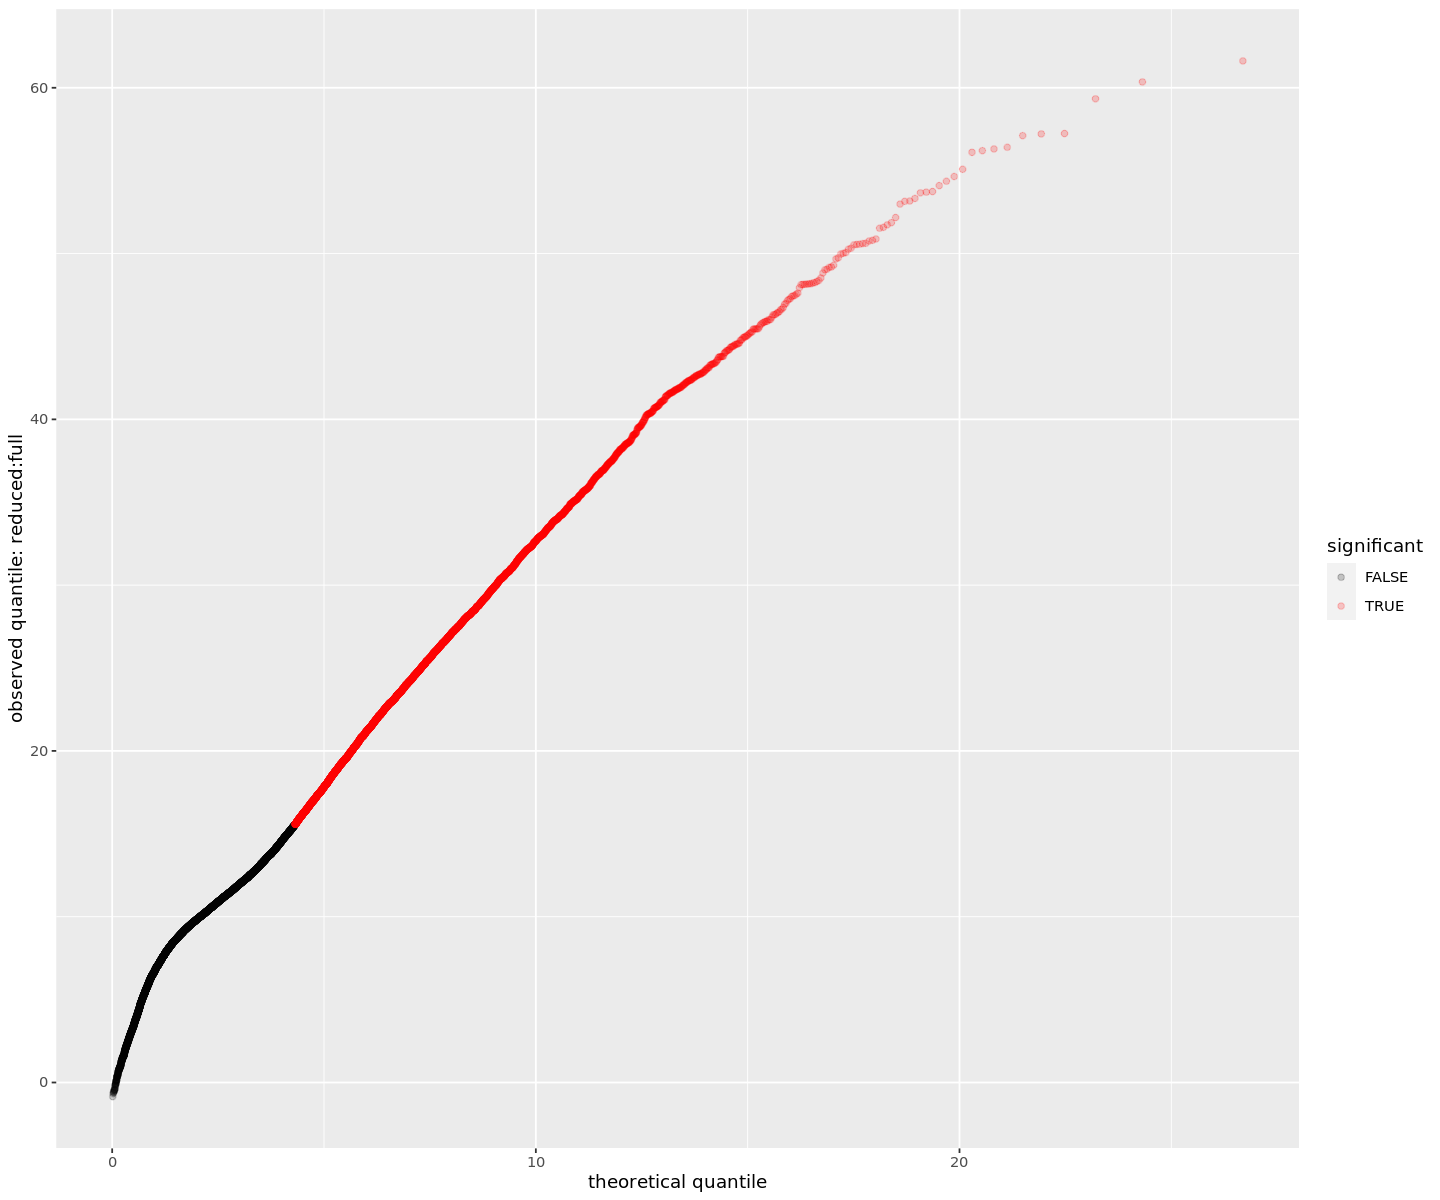

In [55]:
plot_qq(so, test = 'reduced:full', test_type = 'lrt', sig_level = 0.01)

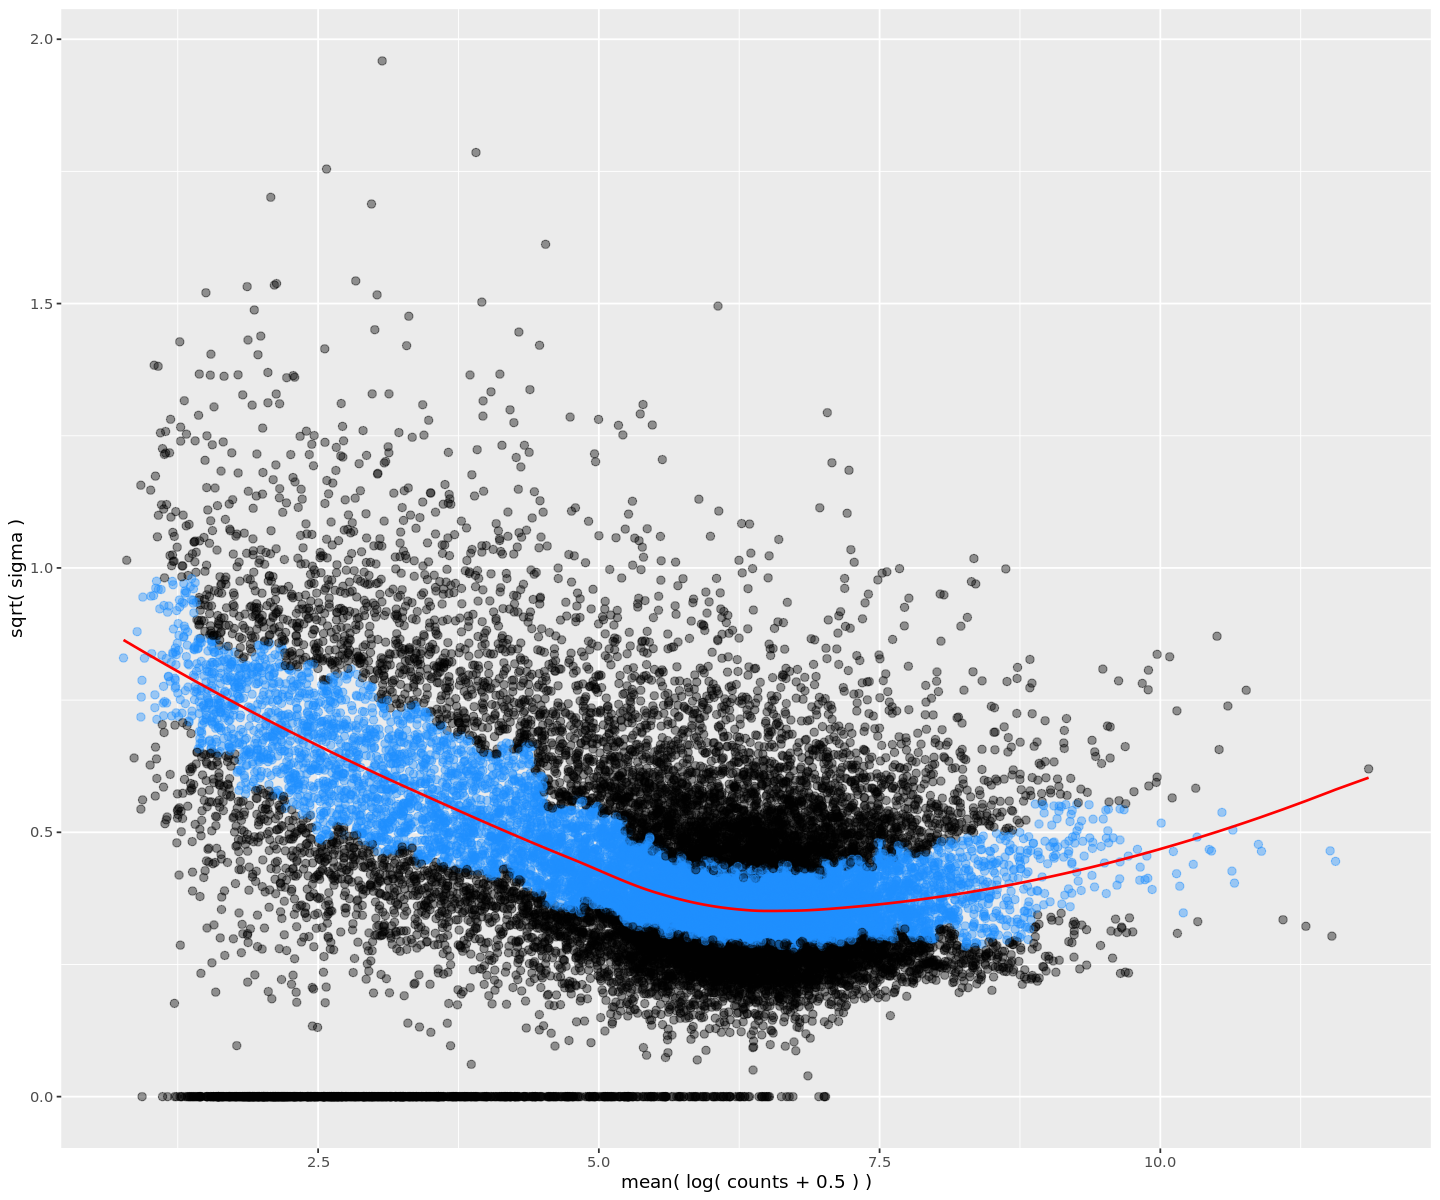

In [57]:
plot_mean_var(so,which_model="full")

In [58]:
lrt_results= sleuth_results(so, 'reduced:full', test_type = 'lrt',show_all=TRUE)

In [60]:
o=lrt_results
o=o[order(-o$test_stat),]
table(o$qval<0.01)
head(o)


FALSE  TRUE 
13825  7927 

,target_id,class,TYPE,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Pp3c1_13200.mRNA,mRNA,mRNA,1.323964e-12,2.660770e-08,61.62035,83.64486,4,3.499105,6.434220,0.033297428,6.400922,0.28276158,6.400922
2,Pp3s49_30.mRNA,mRNA,mRNA,2.446460e-12,2.660770e-08,60.35206,177.52794,4,4.010792,13.655995,0.006823643,13.649171,0.19551171,13.649171
3,Pp3c27_870.mRNA,mRNA,mRNA,4.003216e-12,2.902599e-08,59.33423,72.68902,4,5.048467,5.591463,0.121885115,5.469578,0.07796317,5.469578
10,Pp3c23_22550.mRNA,mRNA,mRNA,1.101617e-11,4.146731e-08,57.24022,78.13027,4,2.390192,6.010021,0.012143106,5.997877,0.53132344,5.997877
6,Pp3c12_9480.mRNA,mRNA,mRNA,1.113520e-11,4.146731e-08,57.21798,77.60833,4,3.240689,5.969872,0.035061400,5.934810,0.33307148,5.934810
7,Pp3c13_6220.mRNA,mRNA,mRNA,1.171338e-11,4.146731e-08,57.11319,97.44026,4,2.682543,7.495404,0.014080861,7.481324,0.45592527,7.481324


In [61]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

,target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
2,Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
3,Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
4,Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
5,Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
6,Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [62]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

,GENEID,name
,<chr>,<chr>
1,Pp3c10_13310,XTH28
2,Pp3c10_13800,"chr1545,CHR1545"
3,Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
4,Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
5,Pp3c10_14020,"RABA53,raba53"
6,Pp3c10_14800,"PPR_20,ppr_20"


In [63]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

,GENEID,source,defline
,<chr>,<chr>,<chr>
1,Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
2,Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
3,Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
4,Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
5,Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
6,Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [64]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

,superfamily,GENEID,inferred_by_rule,TAP_class
,<chr>,<chr>,<chr>,<chr>
1,BSD domain containing,Pp3c11_12590V3,True,PT
2,BSD domain containing,Pp3c1_21290V3,True,PT
3,BSD domain containing,Pp3c20_12230V3,True,PT
4,BSD domain containing,Pp3c23_10600V3,True,PT
5,BSD domain containing,Pp3c24_7080V3,True,PT
6,BSD domain containing,Pp3c26_14480V3,True,PT


In [65]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 39246

[1] 39245

[1] 39245

[1] 39245

[1] 39245

,GENEID,target_id,class.x,TYPE.x,pval,qval,test_stat,rss,degrees_free,mean_obs,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
179,Pp3c1_13200,Pp3c1_13200.mRNA,mRNA,mRNA,1.323964e-12,2.660770e-08,61.62035,83.64486,4,3.499105,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR32401:SF2 - CONCANAVALIN A-LIKE LECTIN FAMILY PROTEIN-RELATED (1 of 5),NA,NA,NA
37758,Pp3s49_30,Pp3s49_30.mRNA,mRNA,mRNA,2.446460e-12,2.660770e-08,60.35206,177.52794,4,4.010792,⋯,true,true,protein_coding_gene,false,NA,pdef,PF06830 - Root cap (Root_cap) (1 of 7),NA,NA,NA
24587,Pp3c27_870,Pp3c27_870.mRNA,mRNA,mRNA,4.003216e-12,2.902599e-08,59.33423,72.68902,4,5.048467,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA
21199,Pp3c23_22550,Pp3c23_22550.mRNA,mRNA,mRNA,1.101617e-11,4.146731e-08,57.24022,78.13027,4,2.390192,⋯,true,"true,false",protein_coding_gene,false,NA,pdef,K01052 - lysosomal acid lipase/cholesteryl ester hydrolase (LIPA) (1 of 2),NA,NA,NA
6181,Pp3c12_9480,Pp3c12_9480.mRNA,mRNA,mRNA,1.113520e-11,4.146731e-08,57.21798,77.60833,4,3.240689,⋯,true,"true,false",protein_coding_gene,false,NA,pdef,1.1.3.9 - Galactose oxidase / Beta-galactose oxidase (1 of 36),NA,NA,NA
7211,Pp3c13_6220,Pp3c13_6220.mRNA,mRNA,mRNA,1.171338e-11,4.146731e-08,57.11319,97.44026,4,2.682543,⋯,true,"false,true",protein_coding_gene,false,"CLL3,cll3",pdef,PTHR27000:SF1 - LEUCINE-RICH REPEAT RECEPTOR-LIKE PROTEIN KINASE TDR (1 of 1),NA,NA,NA


In [66]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,11946
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.x,mRNA
TYPE.x,mRNA
pval,0.01947826
qval,0.03389529
test_stat,11.72975
rss,0.4622573
degrees_free,4
mean_obs,7.321994


In [67]:
head(O[,c("target_id","test_stat","qval","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,qval,name,superfamily,TAP_class,defline
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
179,Pp3c1_13200.mRNA,61.62035,2.660770e-08,NA,NA,NA,PTHR32401:SF2 - CONCANAVALIN A-LIKE LECTIN FAMILY PROTEIN-RELATED (1 of 5)
37758,Pp3s49_30.mRNA,60.35206,2.660770e-08,NA,NA,NA,PF06830 - Root cap (Root_cap) (1 of 7)
24587,Pp3c27_870.mRNA,59.33423,2.902599e-08,NA,NA,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
21199,Pp3c23_22550.mRNA,57.24022,4.146731e-08,NA,NA,NA,K01052 - lysosomal acid lipase/cholesteryl ester hydrolase (LIPA) (1 of 2)
6181,Pp3c12_9480.mRNA,57.21798,4.146731e-08,NA,NA,NA,1.1.3.9 - Galactose oxidase / Beta-galactose oxidase (1 of 36)
7211,Pp3c13_6220.mRNA,57.11319,4.146731e-08,"CLL3,cll3",NA,NA,PTHR27000:SF1 - LEUCINE-RICH REPEAT RECEPTOR-LIKE PROTEIN KINASE TDR (1 of 1)
9995,Pp3c15_7110.mRNA,56.41116,4.146731e-08,NA,NA,NA,PTHR13301//PTHR13301:SF42 - X-BOX TRANSCRIPTION FACTOR-RELATED // SUBFAMILY NOT NAMED (1 of 1)
11713,Pp3c17_13760.mRNA,56.31142,4.146731e-08,NA,NA,NA,"PTHR32227:SF105 - BETA-1,3 GLUCANASE (1 of 6)"
27436,Pp3c4_23600.mRNA,56.20652,4.146731e-08,NA,NA,NA,PF00612//PF13178 - IQ calmodulin-binding motif (IQ) // Protein of unknown function (DUF4005) (DUF4005) (1 of 10)


In [70]:
plot_transcript_heatmap(so, head(O, n = 2)$target_id)

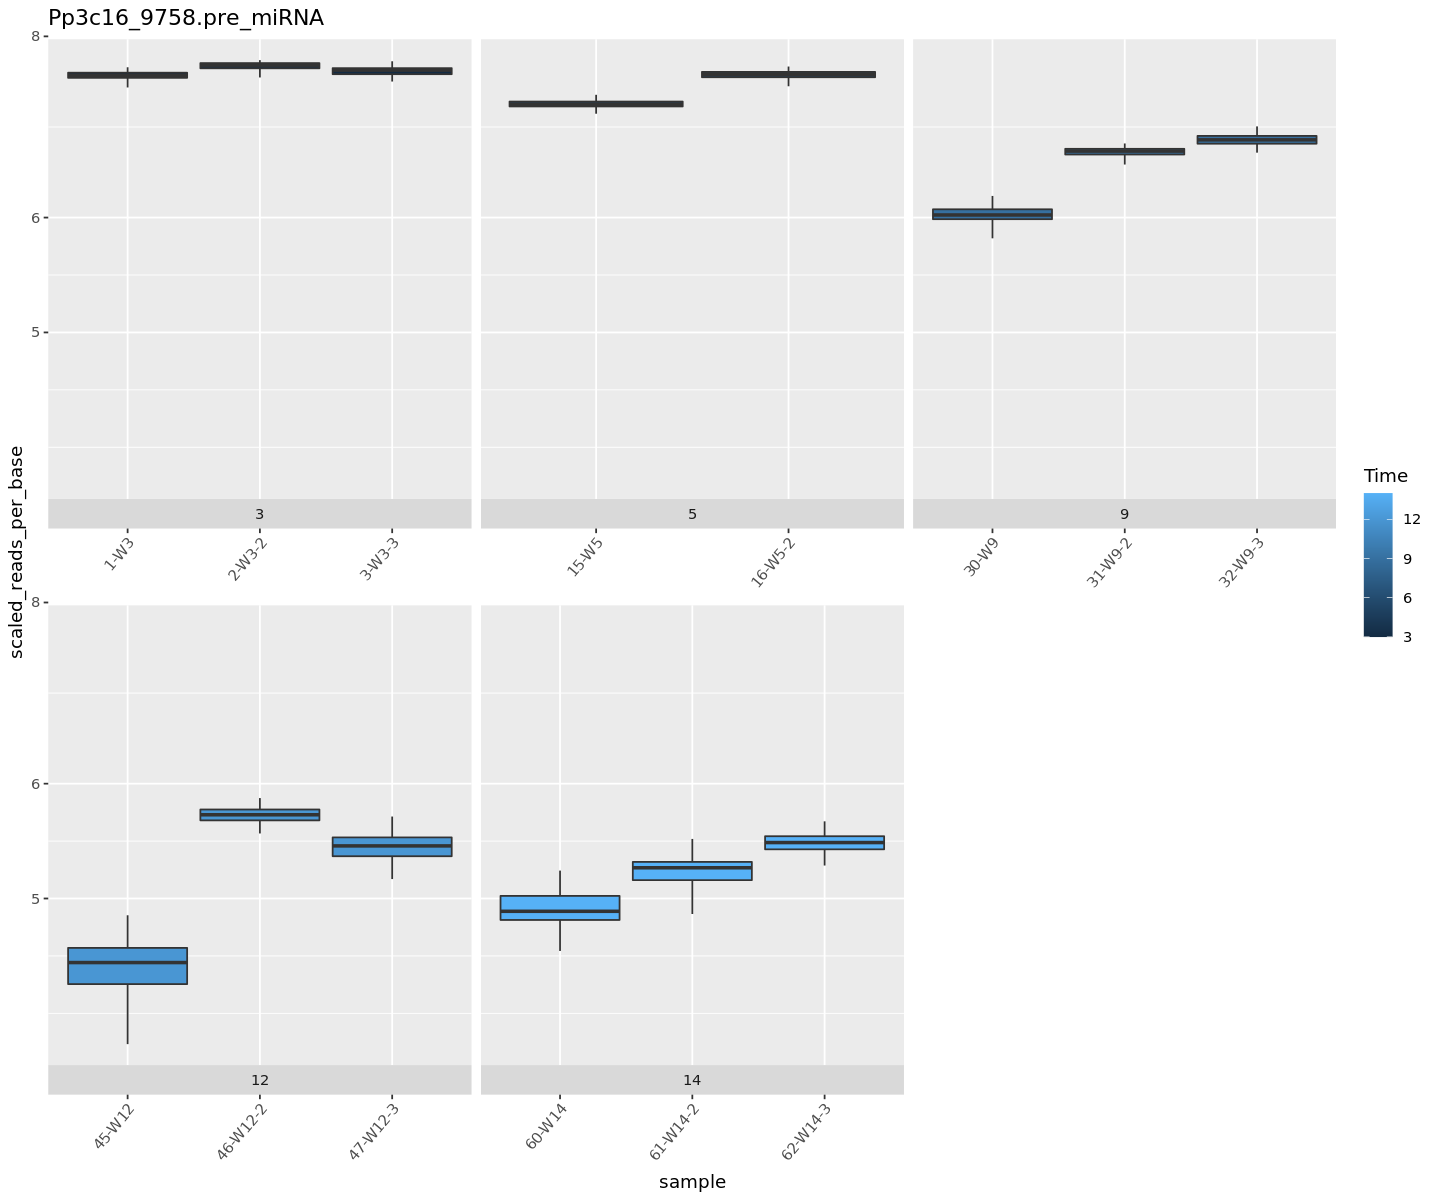

In [77]:
plot_bootstrap(so, 'Pp3c16_9758.pre_miRNA', color_by = 'Time',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [76]:
subset(O,class.x=="pre_miRNA" & qval<0.1)[,c("target_id","test_stat","qval","Alias")]

,target_id,test_stat,qval,Alias
,<chr>,<dbl>,<dbl>,<chr>
11486,Pp3c16_9758.pre_miRNA,33.184574,0.0000294762,"MI0003501,Pp3c16_9758N1.1,ppt-MIR534a,N1.Chr16.ncRNA.50,Pp3c16_9758V1.1"
33899,Pp3c8_7462.pre_miRNA,21.773757,0.0012011075,"ppt-MIR1049,Pp3c8_7462V1.1,N1.Chr08.ncRNA.35,Pp3c8_7462N1.1,MI0006008"
27819,Pp3c4_3072.pre_miRNA,19.567875,0.0025551944,"N1.Chr04.ncRNA.14,ppt-MIR1042,MI0006001,Pp3c4_3072V1.1,ppt-MIR1043,Pp3c4_3072V1.2,MI0006002,Pp3c4_3072N1.1,N1.Chr04.ncRNA.15,Pp3c4_3072N1.2"
21252,Pp3c23_3768.pre_miRNA,19.250098,0.0028379530,"Pp3c23_3768V1.1,ppt-MIR536b,MI0005691,Pp3c23_3768N1.1,N1.Chr23.ncRNA.15"
29860,Pp3c6_12422.pre_miRNA,17.276241,0.0055937691,"Pp3c6_12422N1.1,N1.Chr06.ncRNA.71,ppt-MIR419,Pp3c6_12422V1.1,MI0005670"
20054,Pp3c22_2794.pre_miRNA,14.829746,0.0128385952,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"
7256,Pp3c13_7201.pre_miRNA,13.422802,0.0203317319,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"
8688,Pp3c14_756.pre_miRNA,9.688820,0.0614278051,"N1.Chr14.ncRNA.5,ppt-MIR1030i,MI0005983,ppt-MIR1030f,MI0005980,N1.Chr14.ncRNA.6,Pp3c14_756V1.1,Pp3c14_756N1.1,Pp3c14_756V1.2,Pp3c14_756N1.2"
22493,Pp3c24_7848.pre_miRNA,9.211166,0.0711874325,"Pp3c24_7848V1.1,N1.Chr24.ncRNA.42,Pp3c24_7848N1.1,MI0005932,ppt-MIR536d"


In [78]:
write.table(o,gzfile("comp.WT_time_series/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_time_series/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)